In [1]:
# import libraries
%matplotlib inline
import numpy as np
#import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os
import scipy.spatial
import scipy.stats

In [2]:
# plotting functions
import matplotlib.dates as dates
city = ''
startDate = '1985-01-01'
def easy_scatter(x,y,title, xlabel, ylabel) : 
# plots x,y (need to be np array) and calculates and prints their best fit line
    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    m,b = np.polyfit(x[ind],y[ind],1)
    r, p = scipy.stats.pearsonr(x[ind], y[ind]) #np.corrcoef(x[ind],y[ind])[0,1]
    plt.scatter(x,y)
    plt.plot(x, m*x+b, color = 'black')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    # annotate the linear reqression, y = mx+b
    plt.annotate('y = %.2f x + %.2f'%(m,b), xy=(.5, .9), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('r = %.2f'%(r), xy=(.5, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('p = %.2f'%(p), xy=(.5, .8), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('N = %i'%(ind.shape), xy=(.5, .75), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    return m, r, p
#for UHI, temp, heatwaves in zip([UHImin,UHImax], [tmin,tmax], [minheatwaves, maxheatwaves]): 
def heatwave_scatterplot(UHI, rural_tmin, results_filepath = 'plots/', city = city, filename_flag = ''): 
# compute heatwave and scatterplot UHI versus temp during heatwaves 
        UHI = UHI[startDate:]
        rural_tmin = rural_tmin[startDate:]
        numhw = 150
        finalhw = 50

        hottestmin = rural_tmin.iloc[(-rural_tmin.values).argsort()[:numhw]] 
        minheatwaves = hottestmin

        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index().iloc[np.where(time_diff > np.timedelta64(2, 'D'))]
        # Now the heatwaves are sorted in time order, but we want finalhw (50) of the most severe events. Save the hottest events
        minheatwaves = minheatwaves.sort_values(ascending=False).iloc[0:finalhw]
        
        x = rural_tmin[minheatwaves.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
        y = UHI[minheatwaves.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        
        if ind.sum() > 5: 
            #plt.figure()
            handle = easy_scatter(x[ind],y[ind],'%s HW Temp vs UHI'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$ C)')
            plt.annotate('Rural date range: \n %s - %s'%(rural_tmin.index[0], rural_tmin.index[-1]), xy=(.5, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
            plt.annotate('urban date range: \n %s - %s'%(urban.index[0], urban.index[-1]), xy=(.01, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

            plt.savefig(results_filepath + 'hwstempUHIcatter%s%s'%(city.replace(" ", "")[0:5], 'min') +  filename_flag+ '.png')
            #plt.close()
            
def summertime_scatter(rural_tmin, urban_tmin, results_filepath = 'plots/', city = city,  filename_flag = ''):
    # makes a scatterplot of summertime temp and UHI
    rural_tmin = rural_tmin[startDate:]
    urban_tmin = urban_tmin[startDate:]

    rural_summer = rural_tmin[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)]
    urban_summer = urban_tmin[np.logical_or(urban_tmin.index.month==6, urban_tmin.index.month==7, urban_tmin.index.month==8)]

    rural_summer = rural_summer[(rural_summer>4) & (rural_summer<35)]
    urban_summer = urban_summer[(urban_summer>4) & (urban_summer < 35)]

    #calculate UHI
    UHI = urban_summer - rural_summer

    # Save out the mean temperature and UHI
    x = rural_summer
    y = UHI

    ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
    # plot
    #fig1 = plt.figure()
    handle = easy_scatter(x[ind],y[ind],'%s JJA Temp vs UHI'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$ C)')
    filename = results_filepath+ 'JJAtempUHIscatter%s%s.png'%(city.replace(" ", "")[0:5], 'min') + filename_flag+'.png'
    plt.annotate('Rural date range: \n %s - %s'%(rural_tmin.index[0], rural_tmin.index[-1]), xy=(.5, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('urban date range: \n %s - %s'%(urban.index[0], urban.index[-1]), xy=(.01, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

    plt.savefig(filename)
    #plt.close()
    
def UHI_seasonal_cycle(UHI, rural, temp = 'TMIN', results_filepath = 'plots/', city = city,  filename_flag = ''):
    # makes a climatology of the seasonal cycle
    UHI = UHI[startDate:]
    rural = rural[startDate:]
    time = np.arange('2008-01-01', '2008-12-31', dtype='datetime64[D]')
    fig1 = plt.figure()
    ax = fig1.add_subplot(1,1,1)
    ax.plot(time,
            UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1], color = 'k')
    ax.fill_between(time, 
                     UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1]- UHI.groupby(UHI.index.day_of_year).std().rolling(window=21).mean()[0:-1], 
                     UHI.groupby(UHI.index.day_of_year).mean().rolling(window=30).mean()[0:-1] + UHI.groupby(UHI.index.day_of_year).std().rolling(window=21).mean()[0:-1], color = 'lightgray')

    ax.yaxis.tick_left()
    ax.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    plt.xlabel('Month')
    plt.ylabel('UHI ($\Delta ^\circ$ C)')
    plt.title('Climatological UHI %s %s'%(temp,city))

    max_UHI =  UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean().max()
    max_UHI_location =  UHI.groupby(UHI.index.day_of_year).mean().rolling(window=21).mean().argmax()
    ax.annotate('max', xy=(max_UHI_location, max_UHI),  xycoords='data',
        xytext=(0.8, 0.95), textcoords='axes fraction',
        arrowprops=dict(facecolor='black', shrink=0.05),
        horizontalalignment='right', verticalalignment='top',
        )

    ax2 = fig1.add_subplot(111, sharex=ax, frameon=False)
    #if rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean().shape[0] > 365: 
    line2 = ax2.plot(time, rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean()[0:365], '-.', color = 'k')
    #else : 
    #    line2 = ax2.plot(time, rural.groupby(rural.index.day_of_year).mean().rolling(window=21).mean(), '-.', color = 'k')

    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position("right")
    plt.ylabel('Mean Rural %s'%temp)
    plt.annotate('Rural date range: \n %s - %s'%(rural.index[0], rural.index[-1]), xy=(.5, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
    plt.annotate('urban date range: \n %s - %s'%(urban.index[0], urban.index[-1]), xy=(.01, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

    filename = results_filepath+ 'UHIclimatology'+ city.replace(" ", "")[0:5]+temp+filename_flag+'.png'
    plt.savefig(filename)

In [121]:
# heatwave composites
def heatwave_composite(UHI,temp, results_filepath = 'plots/', city = city, minmax = 'min', filename_flag = ''): 
# compute heatwave and plot it 
        UHI = UHI[startDate:]
        temp = temp[startDate:]
        numhw = 150
        finalhw = 10#50

        hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]] 
        minheatwaves = hottestmin

        # Make sure that events aren't duplicates 
        # get the time difference between events (sorted in temporal order, obviously)
        time_diff = (minheatwaves.sort_index().index.to_timestamp().values[1:] - minheatwaves.sort_index().index.to_timestamp().values[:-1]).astype('timedelta64[D]')
        # find where the events are not within 2 days of each other
        minheatwaves = minheatwaves.sort_index().iloc[np.where(time_diff > np.timedelta64(2, 'D'))]
        # Now the heatwaves are sorted in time order, but we want finalhw (50) of the most severe events. Save the hottest events
        minheatwaves = minheatwaves.sort_values(ascending=False).iloc[0:finalhw]
        
        #x = rural_tmin[minheatwaves.index]#[np.logical_or(rural_tmin.index.month==6, rural_tmin.index.month==7, rural_tmin.index.month==8)] 
        #y = UHI[minheatwaves.index]#[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)] 
        #ind = ~np.isnan(y) & ~np.isnan(x) # subset values that aren't NaNs
        
        # Preallocate composite matrices to plot
        compositeTemp = np.zeros([minheatwaves.shape[0], 11])
        compositeUHI = np.zeros([minheatwaves.shape[0], 11])
        
        i = 0
        for dates in minheatwaves.index[:]: 
            compositeUHI[i,:] = UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            compositeTemp[i,:]= temp[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
            i = i+1

        #if ind.sum() > 5: 
            #handle = easy_scatter(x[ind],y[ind],'%s HW Temp vs UHI'%city, 'Rural Temp ($^\circ$C)', 'UHI ($\Delta ^\circ$ C)')
            #minmax = 'min'
        plt.figure(figsize=[12,4])
        plt.subplot(1,2,1)
        tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
        plt.plot(np.arange(-5,6,1),np.nanmean(compositeTemp, axis=0), linewidth = 3, color = 'black')
        #plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
        try: 
            plt.title('%s %s Temp'%(minmax, city))
        except UnicodeDecodeError : 
            plt.title('%s Temp'%(minmax))

        plt.ylabel('Temp. ($^\circ C$)')
        plt.xlabel('Heatwave Day')

        plt.subplot(1,2,2)    
        uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
        plt.plot(np.arange(-5,6,1),np.nanmean(compositeUHI, axis=0), linewidth = 3,color = 'black')
        try: 
            plt.title('%s %s UHI'%(minmax, city))
        except UnicodeDecodeError :
            plt.title('%s UHI'%(minmax))
        plt.ylabel('UHI $\Delta ^\circ$ C)')
        plt.xlabel('Heatwave Day')
        lgd = plt.legend(minheatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
        plt.annotate('urban date range: \n %s - %s'%(urban.index[0], urban.index[-1]), xy=(.01, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
        plt.annotate('Rural date range: \n %s - %s'%(temp.index[0], temp.index[-1]), xy=(.5, .05), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

        plt.savefig(results_filepath + 'hwcomposite%s%s'%(city.replace(" ", "")[0:5],'min')+filename_flag + '.png')
                        #plt.close()


In [142]:
def do_city_analysis(UHI, rural, results_filepath, filename_flag):
    UHI_seasonal_cycle(UHI, rural = rural, results_filepath = results_filepath, city = city, filename_flag=filename_flag)
    plt.annotate('Urban: %s \n Rural: %s'%(ghcn.loc[urban_id]['name'], ghcn.loc[rural_id]['name']), xy=(.01, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

    # second, compute JJA scatter of JJA rural temp vs. UHI
    plt.figure(figsize=[12,4]) 
    plt.subplot(1,2,1)
    summertime_scatter(rural_tmin = rural, urban_tmin = urban, city = city, results_filepath=results_filepath,  filename_flag= filename_flag)
    plt.annotate('Urban: %s \n Rural: %s'%(ghcn.loc[urban_id]['name'], ghcn.loc[rural_id]['name']), xy=(.01, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

    # third, compute HW scatter of rural HW temp vs. UHI
    plt.subplot(1,2,2)

    heatwave_scatterplot(UHI, rural_tmin = rural, results_filepath = 'plots/', city = city, filename_flag= filename_flag)
    plt.annotate('Urban: %s \n Rural: %s'%(ghcn.loc[urban_id]['name'], ghcn.loc[rural_id]['name']), xy=(.01, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

    # fourth, composite of temperature, UHI
    heatwave_composite(UHI, rural, results_filepath = results_filepath, city = city, minmax = 'min', filename_flag = filename_flag)
    plt.annotate('Urban: %s \n Rural: %s'%(ghcn.loc[urban_id]['name'], ghcn.loc[rural_id]['name']), xy=(.01, .85), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')

In [4]:
# readin in GHCN data 
ghcn = pd.read_fwf('data/ghcnd-stations.txt', colspecs = [(0,11), (12,19), (21,29), (31,36),(38,40), (41,70), (72,74),(76,78),(80,85)], header = None) 
colnames = ['GHCN ID', 'lat', 'lon', 'elevation', 'state', 'name', 'gsn flag', 'HCN/CRN FLAG', 'WMO ID']
ghcn.columns = colnames

# append the brightness index 
BI = np.load('data/brightnessGHCN.npy')
ghcn['Brightness'] = BI
currentstations = ulmo.ncdc.ghcn_daily.get_stations(start_year=1985, end_year = 2016, elements = ['TMIN', 'TMAX', 'AWND'], as_dataframe=True, update=False)
currentGHCNstations = np.intersect1d(currentstations.id, ghcn.index.values) #ghcn['GHCN ID'].values)
ghcnSubset = ghcn.set_index('GHCN ID').loc[currentstations.id.values]
ghcn = ghcnSubset

In [5]:
# generate atlas of cities and k-d tree 
atlas = pd.read_csv('data/sampleAtlas.csv') # derived  from http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-populated-places/
atlas = pd.read_csv('data/world_cities.csv')
tree = scipy.spatial.cKDTree(ghcn[['lon', 'lat']].values, leafsize=100)
atlas = atlas[atlas['pop']> 500000]

brightness_threshold = 30 # this is the urban/rural threshold delimiter
#pairs = []
#for i in range(395, atlas.shape[0]): 
i = 801 # Baltimore
lat = atlas.iloc[i]['lat']
lon = atlas.iloc[i]['lng']
city = atlas.iloc[i]['city']
closeststations = tree.query([lon,lat], k =15, distance_upper_bound=1.5)
closestInds = closeststations[1][~np.isinf(closeststations[0])]


In [152]:
closeststations = tree.query([lon,lat], k =50, distance_upper_bound=2.5)
closestInds = closeststations[1][~np.isinf(closeststations[0])]

In [11]:
closeststations

(array([ 0.01745113,  0.02245578,  0.05832577,  0.09902036,  0.14806831,
         0.24821975,  0.31010622,  0.31128339,  0.32712154,  0.342488  ,
         0.35241179,  0.35363839,  0.37957729,  0.40110649,  0.41185551]),
 array([21838, 22647, 13620, 13660, 22626, 13666, 13607, 13614, 13604,
        13644, 21830, 13635, 13630, 13609, 13606]))

In [17]:
np.setdiff1d(ghcn.iloc[closestInds].index, 'urban_id')

array(['USC00180193', 'USC00180700', 'USC00180732', 'USC00181125',
       'USC00181862', 'USC00182308', 'USC00183675', 'USC00185111',
       'USC00186844', 'USC00188877', 'USC00189750', 'USW00013752',
       'USW00013777', 'USW00093721', 'USW00093784'], dtype=object)

In [19]:
# compute UHI for many stations
city = atlas.iloc[i]['city'] # i = 801
city
urban_id = 'USW00013777'# 'USW00013777' customs house #'USW00093784' #science center
urban_data = ulmo.ncdc.ghcn_daily.get_data(urban_id, as_dataframe=True, update=False)
urban = urban_data['TMIN'].value.astype(float)*.1

#rural_station_list = ['USW00093721', 'USC00182060', 'USC00366289', 'USC00185934', 'USC00186770' ]
#rural_station_list = ['USC00182308', 'USC00369933','USC00362537', 'USC00369950', 'USC00183353' ]
#rural_station_list = ['USW00093721', 'USC00182060', 'USC00366289', 'USC00185934', 'USC00186770' , 'USC00182308', 'USC00369933','USC00362537', 'USC00369950', 'USC00183353' ]
rural_station_list = np.setdiff1d(ghcn.iloc[closestInds].index, urban_id)
results_filepath = 'plots/baltimoreanalysis/'

mean_Bmore_UHIs = np.ones(len(rural_station_list))*np.nan
ii = 0 
for rural_id in rural_station_list: #[2:] : 
    rural_data = ulmo.ncdc.ghcn_daily.get_data(rural_id, as_dataframe=True, update=False)
    try: 
        rural = rural_data['TMIN'].value.astype(float)*.1
        UHI = urban - rural
        UHI = UHI[np.logical_or(UHI.index.month==6, UHI.index.month==7, UHI.index.month==8)]
        mean_Bmore_UHIs[ii] = np.nanmean(UHI)
        
    except KeyError: 
        print 'missing data from station', rural_id
    ii = ii+1

In [20]:
np.nanmean(mean_Bmore_UHIs), np.nanmin(mean_Bmore_UHIs), np.nanmax(mean_Bmore_UHIs)

(3.1998311293668285, 0.0, 5.3359134889015367)

In [52]:
mean_Bmore_UHIs

array([ 2.83533613,  4.17878788,  4.21375718,  5.3060274 ,  5.33591349,
               nan,  4.32224581,  2.75437994,  4.59092303,  3.17215389,
        3.73385189,  0.34456311,  0.        ,  2.52285396,  1.48684211])

In [54]:
closeststations[0]

array([ 0.01745113,  0.02245578,  0.05832577,  0.09902036,  0.14806831,
        0.24821975,  0.31010622,  0.31128339,  0.32712154,  0.342488  ,
        0.35241179,  0.35363839,  0.37957729,  0.40110649,  0.41185551])

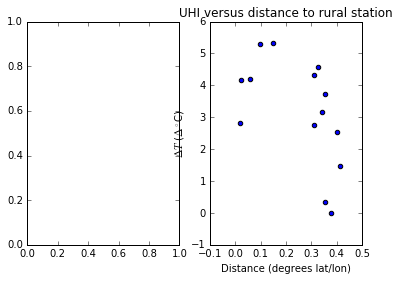

In [65]:
plt.figure()
plt.subplot(1,2,1)


plt.subplot(1,2,2)
plt.scatter(closeststations[0], mean_Bmore_UHIs)
plt.title('UHI versus distance to rural station')
plt.xlabel('Distance (degrees lat/lon)')
plt.ylabel('$\Delta T$ ($\Delta ^\circ$C)')

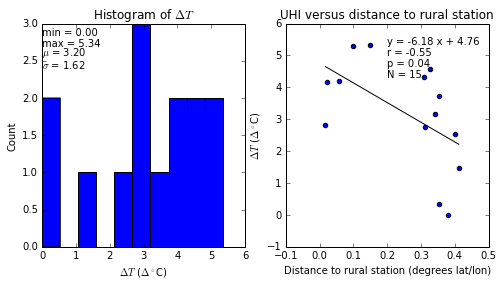

In [84]:
plt.figure(figsize= [8,4])
plt.subplot(1,2,1)
data = mean_Bmore_UHIs[~np.isnan(mean_Bmore_UHIs)]
plt.hist(data)
plt.xlabel('$\Delta T$ ($\Delta ^\circ$C)')
plt.ylabel('Count')
plt.annotate('min = %.2f'%(data.min()), xy=(0, .94), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('max = %.2f'%(data.max()), xy=(0, .89), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$\mu$ = %.2f'%(data.mean()), xy=(0, .84), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.annotate('$\sigma$ = %.2f'%(data.std()), xy=(0, .79), xycoords='axes fraction',  horizontalalignment='left', verticalalignment='bottom')
plt.title('Histogram of $\Delta T$')

plt.subplot(1,2,2)
m,r,p = easy_scatter(closeststations[0], mean_Bmore_UHIs, 
             '$\Delta T$ vs. distance to rural station', 
             'Distance to rural station (degrees lat/lon)', '$\Delta T$ ($\Delta ^\circ$C)',
             )

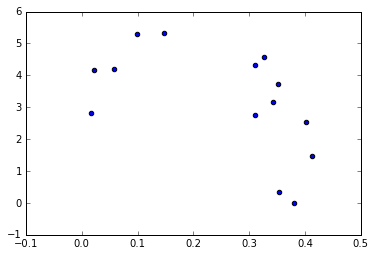

In [56]:
plt.scatter(closeststations[0], mean_Bmore_UHIs)

(array([ 2.,  0.,  1.,  0.,  1.,  3.,  1.,  2.,  2.,  2.]),
 array([ 0.        ,  0.53359135,  1.0671827 ,  1.60077405,  2.1343654 ,
         2.66795674,  3.20154809,  3.73513944,  4.26873079,  4.80232214,
         5.33591349]),
 <a list of 10 Patch objects>)

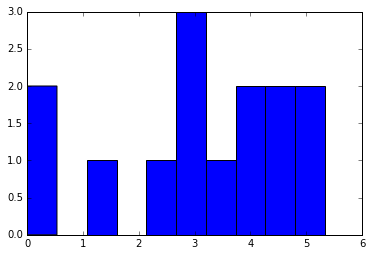

In [60]:
plt.hist(mean_Bmore_UHIs[~np.isnan(mean_Bmore_UHIs)])

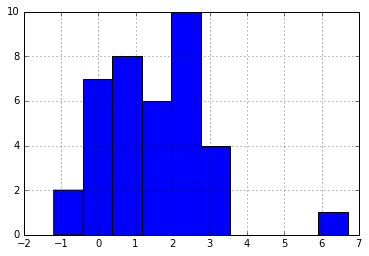

In [51]:
UHI.hist()

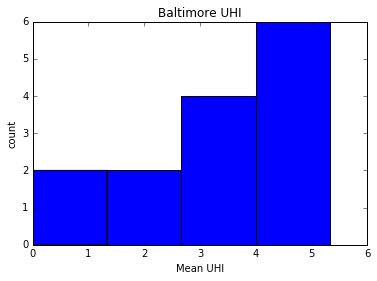

In [49]:
data = mean_Bmore_UHIs
data = data[~np.isnan(data)]
plt.hist(data, bins = 4)
plt.ylabel('count')
plt.xlabel('Mean UHI')
plt.title('Baltimore UHI')

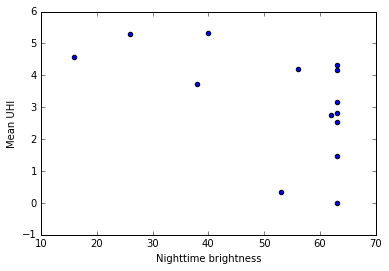

In [41]:
plt.scatter(ghcn.loc[rural_station_list]['Brightness'], mean_Bmore_UHIs)
plt.xlabel('Nighttime brightness')
plt.ylabel('Mean UHI')

In [36]:
ghcn.loc[rural_station_list]

,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID,Brightness
GHCN ID,,,,,,,,,
USC00180193,38.993,-76.507,7.0,MD,ANNAPOLIS POLICE BRKS,NaN,NaN,NaN,63.0
USC00180700,39.030,-76.931,44.0,MD,BELTSVILLE,NaN,HC,NaN,63.0
USC00180732,39.500,-76.383,111.0,MD,BENSON POLICE BARRACKS,NaN,NaN,NaN,56.0
USC00181125,39.191,-77.006,100.0,MD,BRIGHTON DAM,NaN,NaN,NaN,26.0
USC00181862,39.255,-76.928,112.0,MD,CLARKSVILLE 3 NNE,NaN,NaN,NaN,40.0
USC00182308,39.350,-76.650,71.0,MD,CYLBURN,NaN,NaN,NaN,63.0
USC00183675,38.968,-76.804,45.0,MD,GLENN DALE BELL STN,NaN,HC,NaN,63.0
USC00185111,39.084,-76.900,121.0,MD,LAUREL 3 W,NaN,HC,NaN,62.0
USC00186844,39.633,-76.700,182.0,MD,PARKTON 2 SW,NaN,NaN,NaN,16.0


can't do station USC00183353


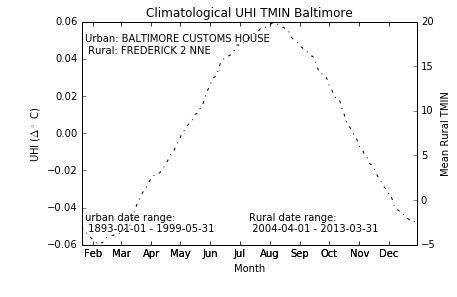

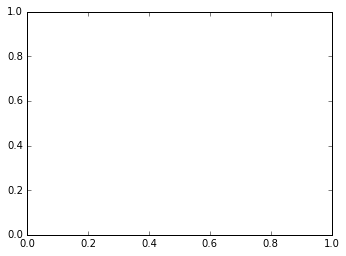

In [164]:
city = atlas.iloc[i]['city'] # i = 801
city
urban_id = 'USW00013777'# customs house#'USW00093784' #science center
urban_data = ulmo.ncdc.ghcn_daily.get_data(urban_id, as_dataframe=True, update=False)
urban = urban_data['TMIN'].value.astype(float)*.1

#rural_station_list = ['USW00093721', 'USC00182060', 'USC00366289', 'USC00185934', 'USC00186770' ]
#rural_station_list = ['USC00182308', 'USC00369933','USC00362537', 'USC00369950', 'USC00183353' ]
rural_station_list = ['USW00093721', 'USC00182060', 'USC00366289', 'USC00185934', 'USC00186770' , 'USC00182308', 'USC00369933','USC00362537', 'USC00369950', 'USC00183353' ]
results_filepath = 'plots/baltimoreanalysis/'

for rural_id in rural_station_list[-1:]: #[2:] : 
    rural_data = ulmo.ncdc.ghcn_daily.get_data(rural_id, as_dataframe=True, update=False)
    try: 
        rural = rural_data['TMIN'].value.astype(float)*.1
        UHI = urban - rural
        filename_flag='ch' + ghcn.loc[rural_id]['name'][0:6]# science center plus
        try: 
            do_city_analysis(UHI, rural, results_filepath = results_filepath, filename_flag = filename_flag)
        except TypeError: 
            print 'can\'t do station', rural_id
    except KeyError: 
        print 'missing data from station', rural_id

In [171]:
atlas[atlas['city']=='Portland']

,city,city_ascii,lat,lng,pop,country,iso2,iso3,province
7022,Portland,Portland,45.520024,-122.67999,1207756.5,United States of America,US,USA,Oregon


In [172]:
atlas[atlas['city']=='Tuscon']

,city,city_ascii,lat,lng,pop,country,iso2,iso3,province


In [163]:
rural_id

'USC00369950'

In [32]:
rural_id = 'USW00093721' #bwi
urban_data = ulmo.ncdc.ghcn_daily.get_data(urban_id, as_dataframe=True, update=False)
rural_data = ulmo.ncdc.ghcn_daily.get_data(rural_id, as_dataframe=True, update=False)
urban = urban_data['TMIN'].value.astype(float)*.1
rural = rural_data['TMIN'].value.astype(float)*.1
UHI = urban - rural
city = atlas.iloc[i]['city']
city

'Baltimore'

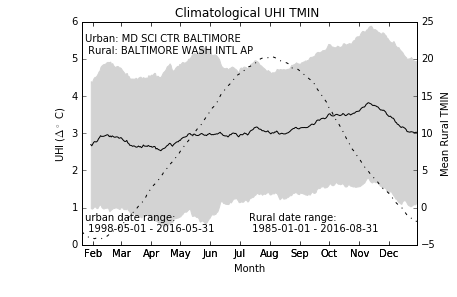

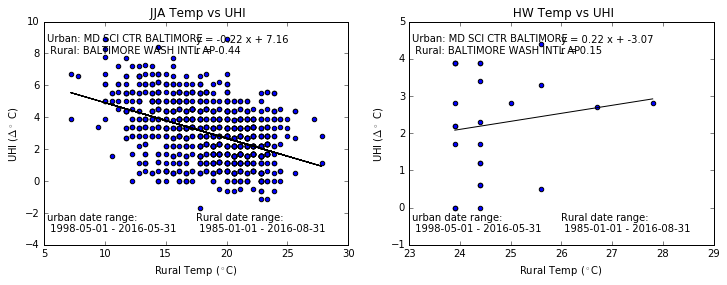

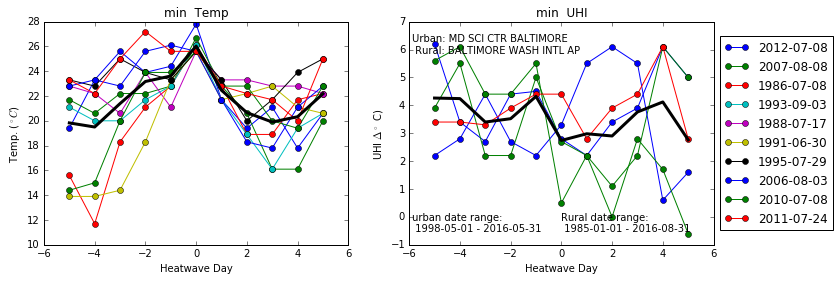

In [143]:
# first, plot yearly UHI cycle
results_filepath = 'plots/baltimoreanalysis/'
filename_flag='scbwi'
do_city_analysis(UHI, rural, results_filepath = results_filepath, filename_flag = filename_flag)

In [ ]:
# fifth, compute composite of humidity
# go from GHCN stations to GSOD stations to get daily precip data
gsod_stations = ulmo.ncdc.gsod.get_stations(country='US')#, state='MD')
matching = [s for s in gsod_stations.keys() if urban_id[6:] in s] #93784
urban_gsod = matching[0]
urban_gsod_data = ulmo.ncdc.gsod.get_data(urban_id,  start='1985-01-01')